# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

### Ознакомление с данными

In [1]:
!pip install phik -q

In [2]:
!pip install --upgrade scikit-learn -q

In [3]:
!pip install matplotlib==3.5.0 -q

In [4]:
#импортируем все необходимые библиотеки, а также расширим ячейки
import pandas as pd
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

import time

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# загружаем нужные модели

from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

from sklearn.metrics import make_scorer


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib.pyplot as plt

#установим везде графики с одинаковым размером
plt.rcParams["figure.figsize"] = (15,5)

In [5]:
#загрузим датафрейм в переменную autos
autos = pd.read_csv('/datasets/autos.csv')

In [6]:
#выведем первые пять строк из таблицы для знакомства с датафреймом
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
#выведем общую информацию по таблице
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Промежуточный вывод:** Всего в таблице 354369 строк, 16 столбцов. Имеются пропущенные значения. С таблицей познакомились. Далее необходимо проверить и удалить пропуски, проверить категориальные столбцы на наличие явных и неявных дубликатов, исправить названия столбцов в соответсвии со змеиным регистром, а также исправить формат строк в столбцах в соответствии с информацией.

### Предобработка данных

In [8]:
#приведем все названия столбцов в нижний регистр
autos.columns = autos.columns.str.lower()

In [9]:
#проверка
autos.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'repaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [10]:
#приведем названия столдцов к нужному формату
autos = autos.rename(columns={'datecrawled': 'date_crawled', 'vehicletype': 'vehicle_type', 'registrationyear': 'registration_year', 'registrationmonth' : 'registration_month', 'fueltype' : 'fuel_type', 'datecreated' : 'date_created', 'numberofpictures' : 'number_of_pictures', 'postalcode' : 'postal_code', 'lastseen' : 'last_seen'})

In [11]:
#проверка
autos.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [12]:
#изменим формат данных в столбцах date_crawled, date_created, last_seen
autos['date_crawled'] = pd.to_datetime(autos['date_crawled'])
autos['date_created'] = pd.to_datetime(autos['date_created'])
autos['last_seen'] = pd.to_datetime(autos['last_seen'])

In [13]:
#проверка
autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        316879 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             334536 non-null  object        
 5   power               354369 non-null  int64         
 6   model               334664 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           321474 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            283215 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [14]:
#проверка
autos.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21


In [15]:
#проверим таблицу на наличие пропусков и посчитаем их кол-во в каждом столбце
autos.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [17]:
#заменим все пропуски на unknown
autos.fillna('unknown', inplace=True)

In [18]:
#повторная проверка
autos.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [19]:
#после удаления всех пропусков, займемся явными и неявными дубликатами.
#определим присутвуют ли они в категориальных столбцах, а также внесем соответсвующие исправления
#определим категориальные столбцы
cat_columns = ['vehicle_type', 'registration_year', 'gearbox', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired', 'number_of_pictures']

In [20]:
autos.duplicated().sum()

4

In [21]:
autos = autos.drop_duplicates()

In [22]:
#проверка
autos.duplicated().sum()

0

In [23]:
#проверка датафрейма на неявные дубликаты в категориальных столбцах
for i in cat_columns:
    print(autos[i].unique()),
    print('\n')

['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']


[1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]


['manual' 'auto' 'unknown']


['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_k

**Промежуточный вывод:** успешно предобработали таблицу. Удалили пропуски, привели к правильному формату названия столбцов, удалили явные дубликаты, а также изменили форматы данных в нужных столбцах на тип datetime.

### Исследовательский анализ данных

In [24]:
autos.head(2)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50


In [25]:
#определим наши количественные столбцы
num_columns = ['price', 'power']
#определим категориальные столбцы
cat_columns = ['vehicle_type', 'registration_year', 'gearbox', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand', 'repaired', 'number_of_pictures']

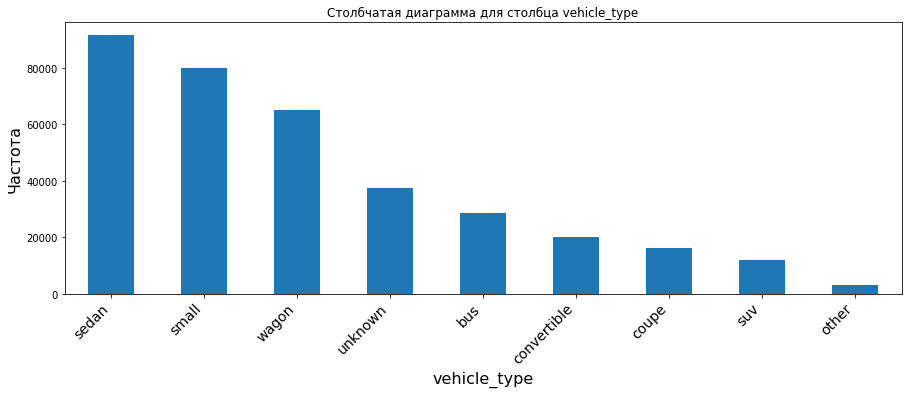

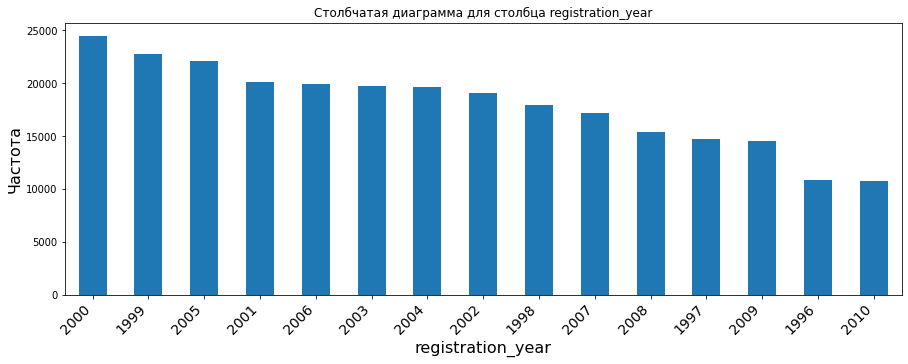

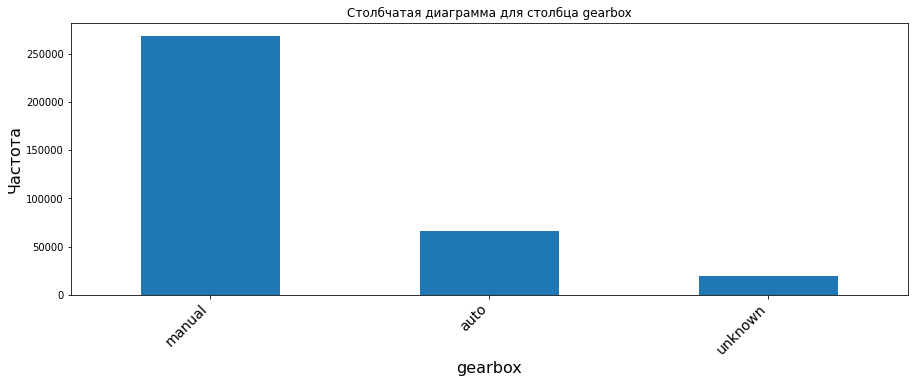

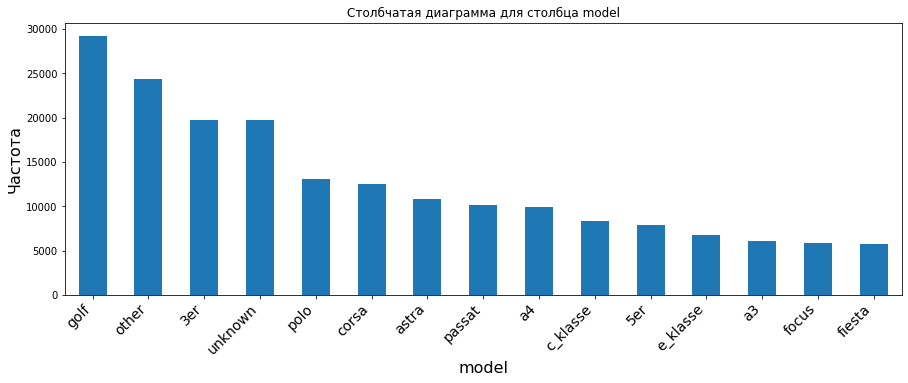

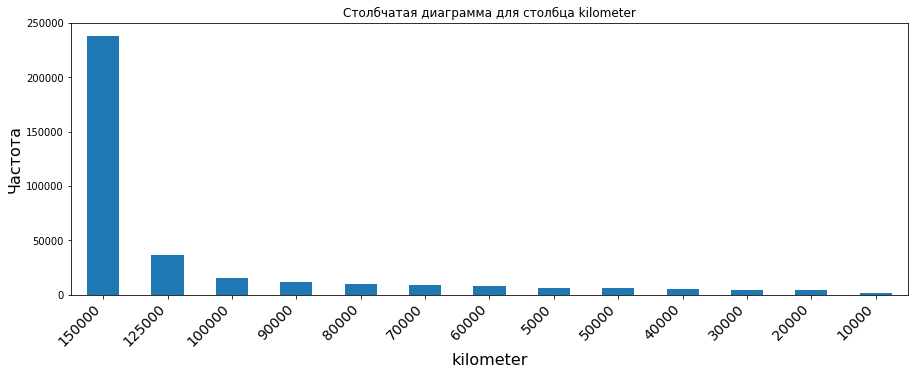

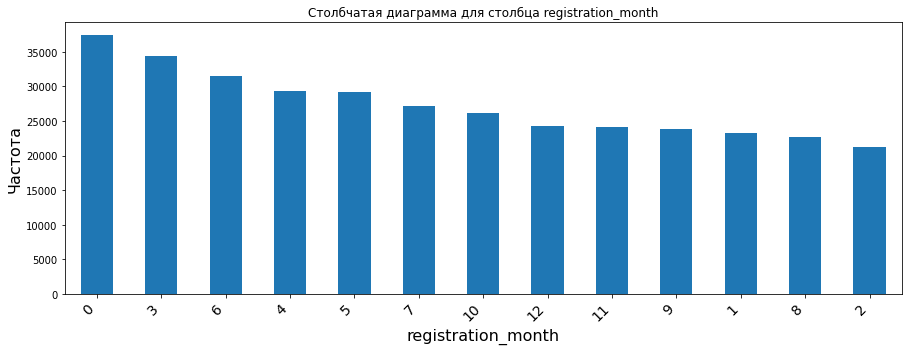

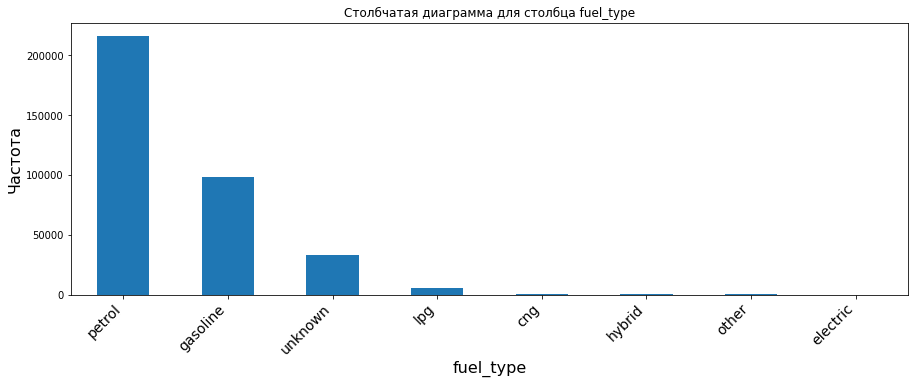

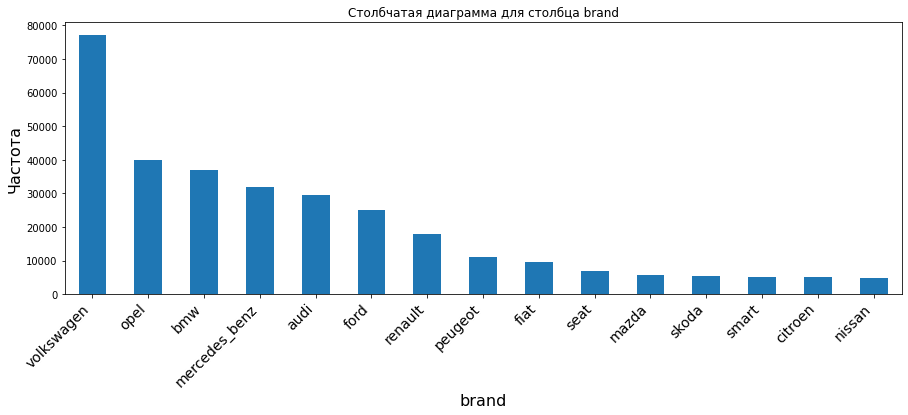

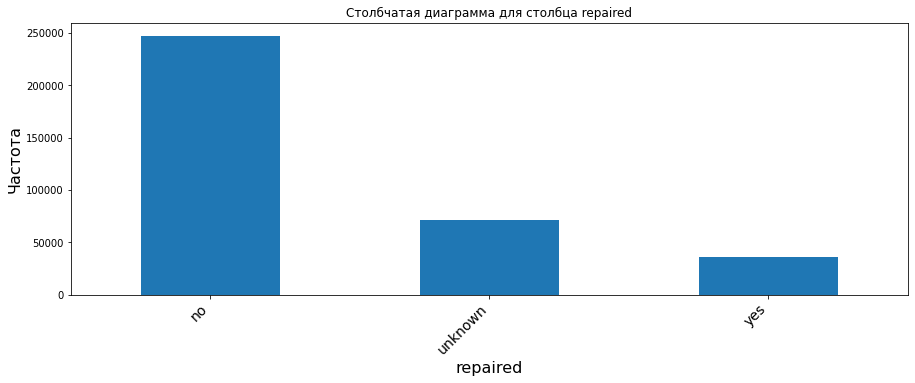

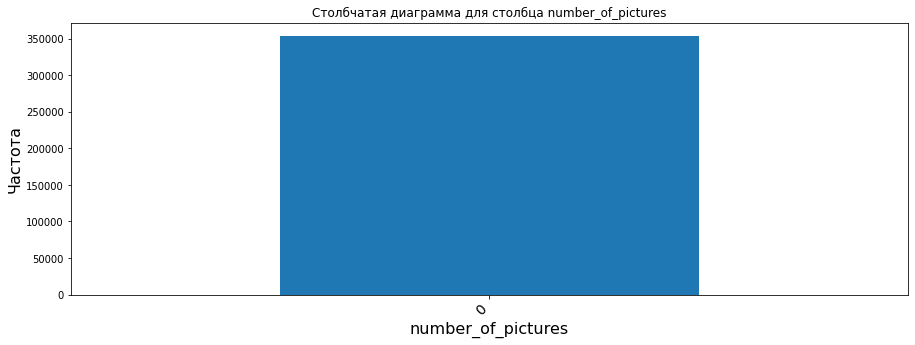

In [26]:
#с помощью цикла выведем гистограммы для каждого категориального столбца
for i in autos[cat_columns]:
    autos[i].value_counts().head(15).plot(kind='bar')
    plt.ylabel('Частота', fontsize=16)
    plt.xlabel(i, fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.title(f'Столбчатая диаграмма для столбца {i}')
    plt.show()

In [27]:
#сделаем срез по году регистрации
autos = autos.query('registration_year < 2016')
autos = autos.query('registration_year > 1980')

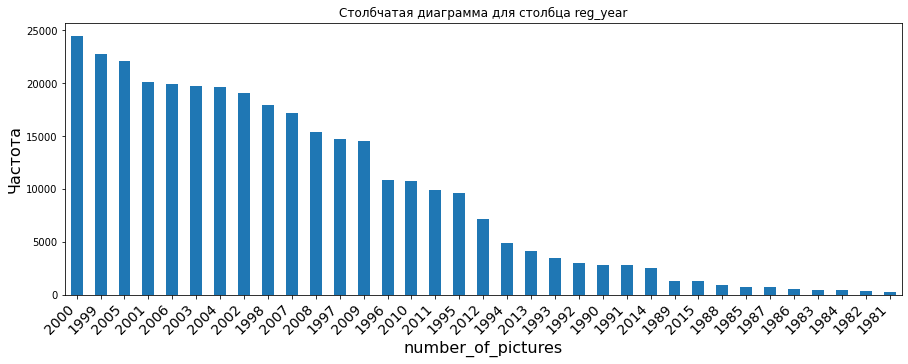

In [28]:
autos['registration_year'].value_counts().plot(kind='bar')
plt.ylabel('Частота', fontsize=16)
plt.xlabel(i, fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.title(f'Столбчатая диаграмма для столбца reg_year')
plt.show()

**аномалий не обнаружено в категориальных столбцах**

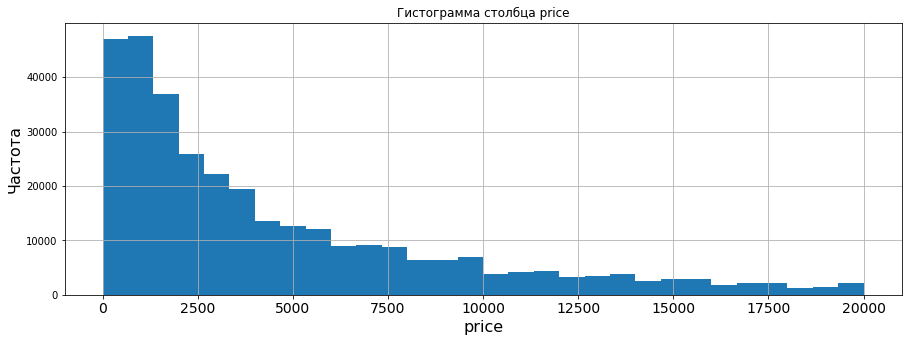

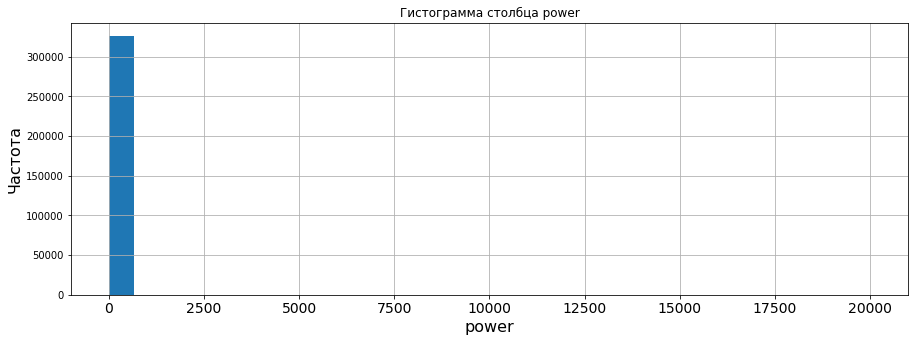

In [29]:
#с помощью цикла выведем гистограммы для каждого количественного столбца
for i in autos[num_columns]:
    autos[i].hist(bins=30)
    plt.ylabel('Частота', fontsize=16)
    plt.xlabel(i, fontsize=16)
    plt.title(f'Гистограмма столбца {i}')
    plt.xticks(fontsize=14)
    plt.show()

**Обнаружены аномалии в столбце power, явный выброс который можно удалить.**

In [30]:
#удалим аномальные значения
autos = autos.query('power < 600')
autos = autos.query('power > 40')

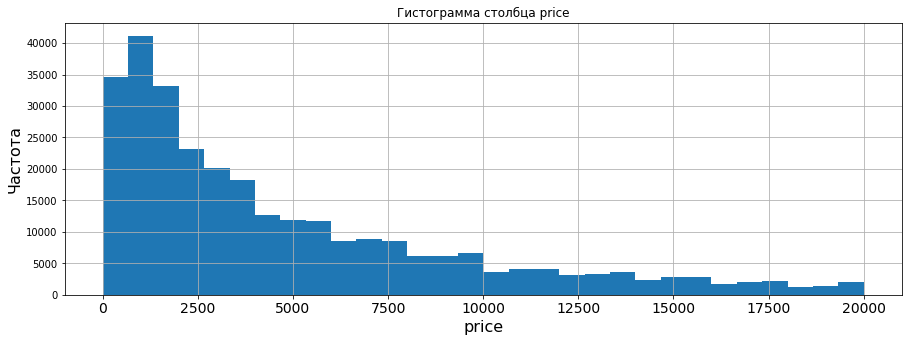

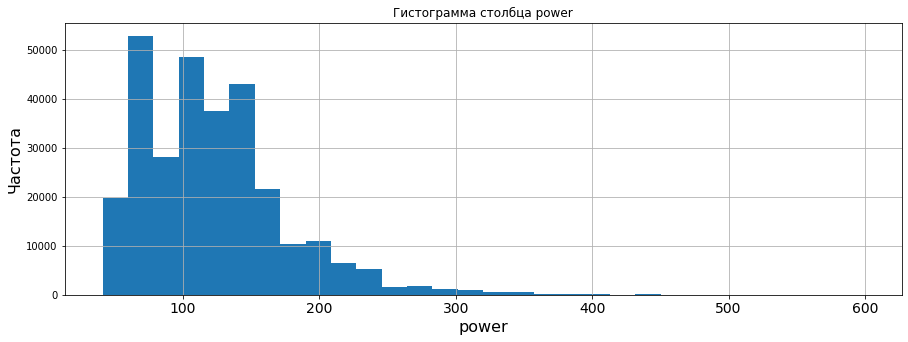

In [31]:
#с помощью цикла выведем гистограммы для количественного столбца power (повторно)
for i in autos[num_columns]:
    autos[i].hist(bins=30)
    plt.ylabel('Частота', fontsize=16)
    plt.xlabel(i, fontsize=16)
    plt.title(f'Гистограмма столбца {i}')
    plt.xticks(fontsize=14)
    plt.show()

**аномалии в количественном столбце power были успешно удалены, больше аномалий не обнаружено**

### Проверка признаков на мультиколлинеарность

In [32]:
# Оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    '''
    Function optimizes memory usage in dataframe
    df: pd.DataFrame - data table
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                            .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [33]:
#применим нашу функцию 
autos = optimize_memory_usage(autos)

Размер использования памяти: до 37.92 Mb - после 26.77 Mb (29.4%)


In [34]:
interval_cols = ['power']

In [35]:
#так как мы будем обучать одну линейную модель, то необходимо проверить все входные признаки на мультиколлинеарность. (удалим цену (целевой признак) и входные признаки никак не влияющие на ценообразование машины) 
phik_overview = autos.drop(['number_of_pictures', 'date_crawled', 'date_created', 'last_seen', 'postal_code'], axis=1).phik_matrix(interval_cols=interval_cols)

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable price is large: 3557. Are you sure this is not an interval variable? Analysis for pairs of variables including price can be slow.
  warnings.warn(


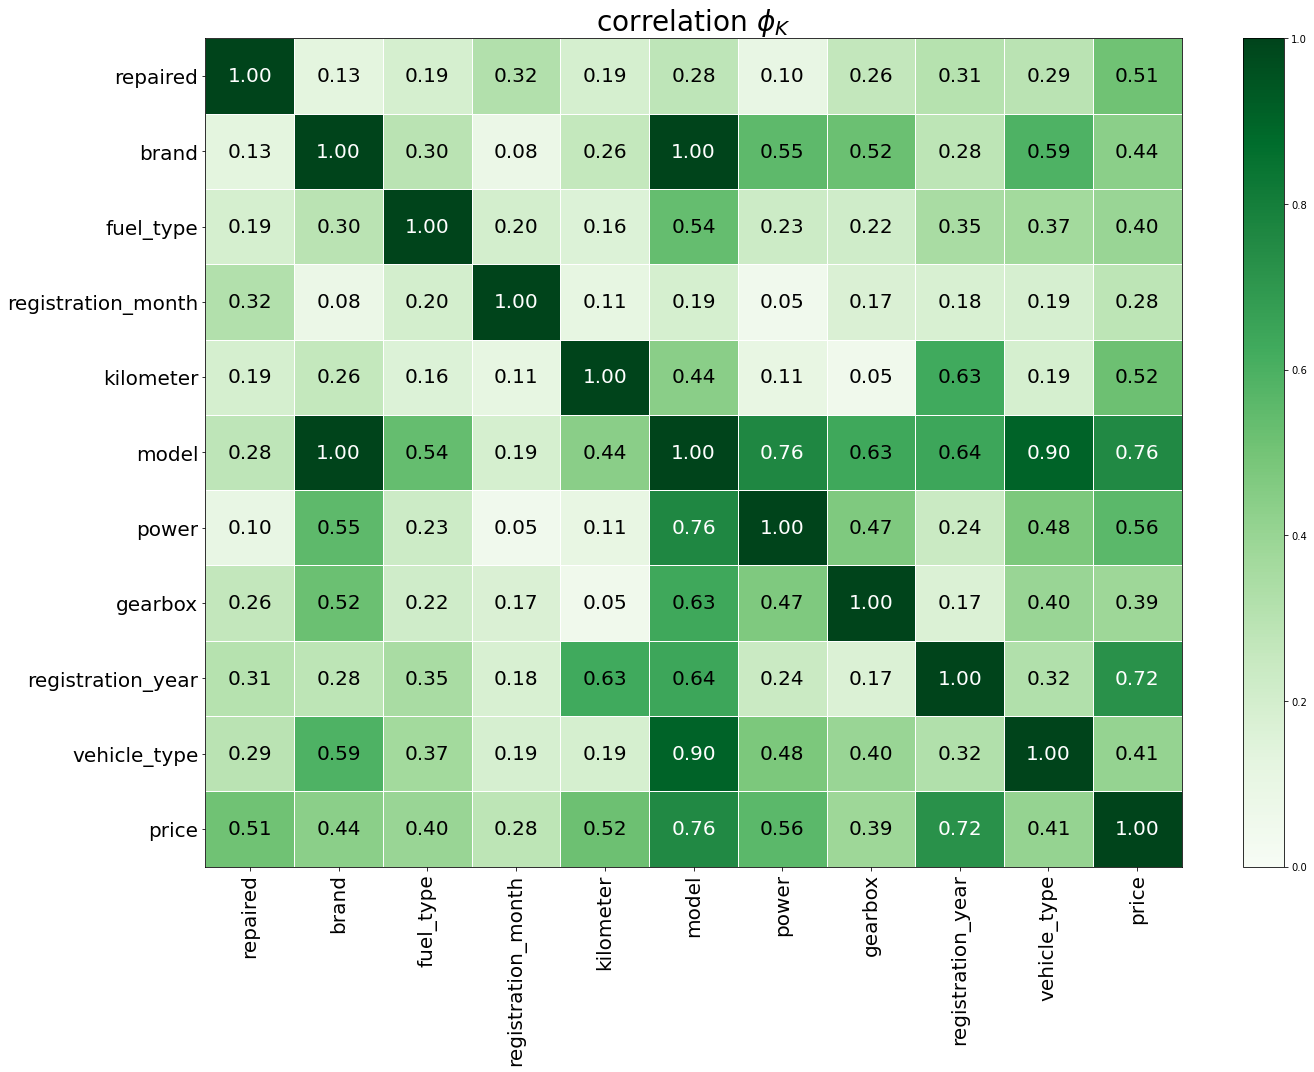

In [36]:
# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=2,
    figsize=(20, 15)
) 

**Обнаружена мультиколлинеарность между входными признаками model и brand, а также vehicle_type и model. При обучении моделей линейной регрессии следует удалить признак brand, так как есть хорошая зависимость между ценой и model (0.74).**

In [37]:
autos.registration_year.describe()

count    292390.000000
mean       2002.747307
std           5.599844
min        1981.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        2015.000000
Name: registration_year, dtype: float64

**Вывод по разделу:** успешно провели предобработку и исследовательский анализ данных. Удалили лишние аномалии, обработали пропуски, выявили явные и неявные дубликаты.

## Обучение моделей

In [38]:
#выведем повторно таблицу для удобства
autos.head(2)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46


In [39]:
#подготовим пайплайн
#построим модели и проверим их гиперпараметры с помощью пайплайна на тренировочной выборке

RANDOM_STATE = 42

X = autos.drop(['price', 'registration_month', 'number_of_pictures', 'date_crawled', 'date_created', 'last_seen', 'postal_code', 'brand'], axis=1)
y = autos['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [40]:
#выделем колонки для кодирования столбцов
ohe_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'repaired']

num_columns = ['registration_year', 'power', 'kilometer']

In [41]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: OHE-кодирование
ohe_pipe = Pipeline(
    [
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    ]
    )

In [42]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [43]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])



In [44]:
param_random = [
    # словарь для модели LGBMRegressor()
      {
        'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None, 10],
        'models__min_data_in_leaf': [1, 5],  # Пример настройки параметра
        'preprocessor__num': [MinMaxScaler(), 'passthrough']
    },
        # словарь для модели LinearRegression()
     {
        'models': [LinearRegression()],
        'preprocessor__num': [MinMaxScaler(), 'passthrough']
    }
]


In [45]:
# Сначала определим функцию, которая вычисляет RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Теперь создаем scorer объект.
# greater_is_better=False указывает, что чем МЕНЬШЕ значение, тем лучше.
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [46]:
# Засекаем общее время
start_time = time.time()

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_random, 
    cv=5,
    n_iter = 5,
    scoring = rmse_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)
print('Лучшая модель и её параметры', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

end_time = time.time()
total_time = end_time - start_time
print(f"Общее время обучения: {total_time:.2f} секунд")

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5


/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
Лучшая модель и её параметры Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['vehicle_type', 'gearbox',
                                             

**Промежуточный вывод:** Обучили разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовали разные гиперпараметры.
Проанализировали время обучения.

In [47]:
result = pd.DataFrame(randomized_search.cv_results_)

In [48]:
result[['mean_fit_time', 'param_models', 'param_models__min_data_in_leaf', 'param_models__max_depth', 'mean_test_score']]

,mean_fit_time,param_models,param_models__min_data_in_leaf,param_models__max_depth,mean_test_score
0,14.105566,LinearRegression(),NaN,NaN,-2434.285066
1,6.272558,LGBMRegressor(random_state=42),1.0,None,-1750.783846
2,5.596758,LGBMRegressor(random_state=42),1.0,10,-1768.374373
3,6.053037,LGBMRegressor(random_state=42),1.0,None,-1749.853183
4,7.472896,LGBMRegressor(random_state=42),5.0,10,-1766.304425


**Вывод по разделу:** успешно обучили модель на различных гиперпараметрах. Посмотрели результаты по каждой модели. Лучшая модель - LGBMRegressor(max_depth=None, min_data_in_leaf=1,
                               random_state=42)) как по времени обучения, так и по качеству.

## Анализ моделей

In [49]:
# извлекаем модель и трансформер из обученной модели
model = randomized_search.best_estimator_.named_steps['models']
pre = randomized_search.best_estimator_.named_steps['preprocessor']
# трансформируем данные
X_train_processed = pre.transform(X_train)
X_test_processed  = pre.transform(X_test)
# сохраняем признаков после всех трансформаций
feature_names = pre.get_feature_names_out()
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
X_test_df  = pd.DataFrame(X_test_processed,  columns=feature_names)

model.fit(X_train_df, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


LGBMRegressor(max_depth=None, min_data_in_leaf=1, random_state=42)

In [50]:
# Засекаем общее время
start_time = time.time()
y_pred = model.predict(X_test_df)
end_time = time.time()
total_time = end_time - start_time
print(f"Общее время предсказания: {total_time:.2f} секунд")

Общее время предсказания: 0.80 секунд


In [51]:
y_test = y_test.to_numpy()

In [52]:
scoring_best_model = rmse(y_test, y_pred)
print('Метрика лучшей модели на тестовой выборке:', scoring_best_model)

Метрика лучшей модели на тестовой выборке: 1740.4434653436235


**Итоговый вывод:** Загрузили и подготовили данные, обучили разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовали разные гиперпараметры.
Проанализировали время обучения, время предсказания и качество моделей.
Опираясь на критерии заказчика, выбрали лучшую модель, проверили её качество на тестовой выборке (менее 2500, что соответствует требованиям задачи).

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей